<a href="https://colab.research.google.com/github/TheodorIvanov/Summer_Project/blob/master/summer_project_nns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Data

In [9]:
from google.colab import files # insert json token

import json # alternatively can use files.upload()
dict = {"username":"tedbg41","key":"e8b997c78473e26b4bec20ca33c9ca66"}
with open('kaggle.json', 'w') as fp:
    json.dump(dict, fp)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Downloading the Zip database from Kaggle
!kaggle datasets download -d mlg-ulb/creditcardfraud

# Unzipping the file
import zipfile
with zipfile.ZipFile("creditcardfraud.zip","r") as zip_ref:
    zip_ref.extractall()

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


## Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
sns.set_palette("Set2")
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras
from keras.layers import *
from keras import losses
from keras import optimizers
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

seed = 66

# Supressing  Warnings

import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

# Functions

def LossGraph(history):
  plt.figure(figsize = (12,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show();

def ReconstructionScatter(cleared, frauds, threshold): 
  plt.figure(figsize = (12,9))
  plt.scatter(cleared.index, cleared.values, marker = 'o', label = 'Cleared')
  plt.scatter(frauds.index, frauds.values, marker = 'x', label = 'Fraud')
  plt.hlines(threshold, plt.xlim()[0], plt.xlim()[1], colors = 'r', label = 'Threshold')
  plt.legend(loc = 'best')
  plt.title('Reconstructed Transactions')
  plt.xlabel('Transaction ID')
  plt.ylabel('Root Reconstruction Error')
  plt.show();

def ModelPerformance(X_test, y_test, prediction):
  print('\n Confusion Matrix \n =================================== \n')
  sns.heatmap(confusion_matrix(y_test,prediction), annot = True, cmap='RdBu', fmt='g', cbar=False)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show();
  print('\n Classification Report \n =================================== \n', classification_report(y_test,prediction))


## Sampling

In [33]:
# Scaling the data

df = pd.read_csv('creditcard.csv')
scaled = pd.DataFrame(StandardScaler().fit_transform(df.drop(['Time','Class'], axis=1)),
                      columns=df.drop(['Time','Class'],axis=1).columns) # scaling all columns apart from Time and Class
scaled['Class'] = df['Class']

# Splitting the data

train, test = train_test_split(scaled, test_size = 0.2, random_state = seed)

X_train = (train[train.Class == 0]).drop(['Class'], axis = 1) # using only the cleared transactions for training
X_test = test.drop(['Class'], axis=1)
y_test = test['Class']

input_dim = X_train.shape[1] # input dimensions for the neural networks

## Model 1: Simple Autoencoder

In [ ]:
# latent = 9 # dimension of the latent vector
# batch_size = 128
# epochs = 100

# # Defining the Model

# inputs = Input(shape=(input_dim,), name = 'input_encoder')

# encoder = Dense(18, activation='relu')(inputs)
# encoder = Dense(12, activation='relu')(encoder)

# bottleneck  = Dense(latent, activation='relu')(encoder)

# decoder = Dense(12, activation='relu')(bottleneck)
# decoder = Dense(18, activation='relu')(decoder)
# decoder = Dense(input_dim, activation='relu')(decoder)

# autoencoder_1 = Model(inputs,decoder)
# # autoencoder_1.summary()
# # keras.utils.plot_model(autoencoder_1, show_shapes=True)

# # Compiling the model

# autoencoder_1.compile(optimizer=keras.optimizers.Adam(),
#                       loss = losses.mean_squared_error,
#                       metrics = ['mae','accuracy'])

# # Early Stopper

# stopper = EarlyStopping(monitor = 'val_loss',
#                         min_delta = 0.005,
#                         verbose = 1,
#                         patience = 5,
#                         restore_best_weights = True)

# # Training

# history = autoencoder_1.fit(X_train, X_train,
#                             batch_size = batch_size,
#                             epochs = epochs,
#                             verbose = 2,
#                             validation_data = (X_test, X_test),
#                             callbacks = [stopper])

# LossGraph(history)

# # Predicting

# predictions = autoencoder_1.predict(X_test)

# # Reconstruction error (RMSE)

# rmse = np.sqrt(np.mean(np.power(X_test - predictions, 2), axis = 1))

# # Reconstructed data

# reconstructed = pd.DataFrame({'rec_error': rmse,'true_class': y_test})

# frauds = reconstructed[reconstructed.true_class == 1].drop('true_class', axis = 1)
# cleared = reconstructed[reconstructed.true_class == 0].drop('true_class', axis = 1)

# # Predicting the class using the threshtold

# threshold = 5

# reconstructed['pred_class'] = 0
# reconstructed.pred_class[reconstructed.rec_error > threshold] = 1

# # Model Performance

# ReconstructionScatter(cleared, frauds, threshold = threshold)
# ModelPerformance(X_test, y_test, reconstructed.pred_class)

## Feature Selection

In [ ]:
# Feature Selection

scaled = scaled.iloc[:, [2, 3, 8, 9, 10, 11, 13, 15, 16, 17, -1]]

# Splitting the data

train, test = train_test_split(scaled, test_size = 0.2, random_state = seed)

X_train = (train[train.Class == 0]).drop(['Class'], axis = 1) # using only the cleared transactions for training
X_test = test.drop(['Class'], axis=1)
y_test = test['Class']

input_dim = X_train.shape[1] # input dimensions for the neural networks

## Model 2

Train on 227448 samples, validate on 56962 samples
Epoch 1/100
 - 7s - loss: 0.5160 - mae: 0.4585 - accuracy: 0.7803 - val_loss: 0.5351 - val_mae: 0.4009 - val_accuracy: 0.9208
Epoch 2/100
 - 7s - loss: 0.4571 - mae: 0.3815 - accuracy: 0.9463 - val_loss: 0.5286 - val_mae: 0.3942 - val_accuracy: 0.9252
Epoch 3/100
 - 7s - loss: 0.4544 - mae: 0.3680 - accuracy: 0.9742 - val_loss: 0.5242 - val_mae: 0.3705 - val_accuracy: 0.9814
Epoch 4/100
 - 7s - loss: 0.4538 - mae: 0.3629 - accuracy: 0.9834 - val_loss: 0.5241 - val_mae: 0.3716 - val_accuracy: 0.9788
Epoch 5/100
 - 7s - loss: 0.4537 - mae: 0.3613 - accuracy: 0.9866 - val_loss: 0.5266 - val_mae: 0.3917 - val_accuracy: 0.9248
Epoch 6/100
 - 7s - loss: 0.4536 - mae: 0.3602 - accuracy: 0.9885 - val_loss: 0.5236 - val_mae: 0.3661 - val_accuracy: 0.9883
Epoch 7/100
 - 7s - loss: 0.4535 - mae: 0.3598 - accuracy: 0.9896 - val_loss: 0.5236 - val_mae: 0.3658 - val_accuracy: 0.9899
Restoring model weights from the end of the best epoch
Epoch 00007:

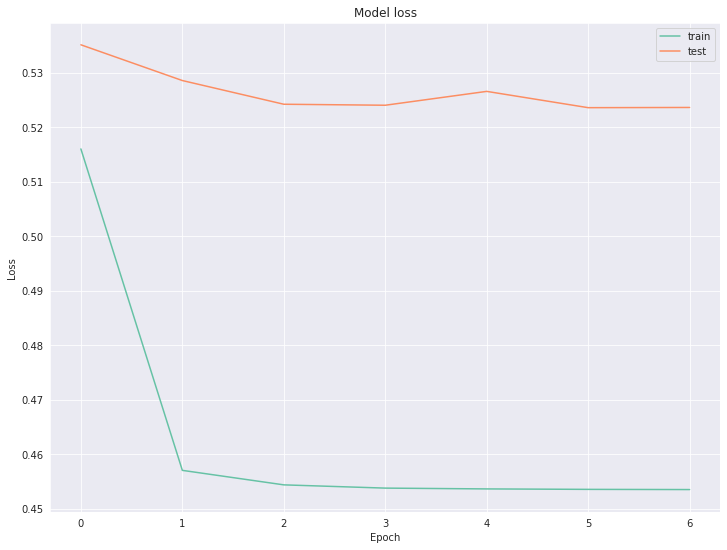

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


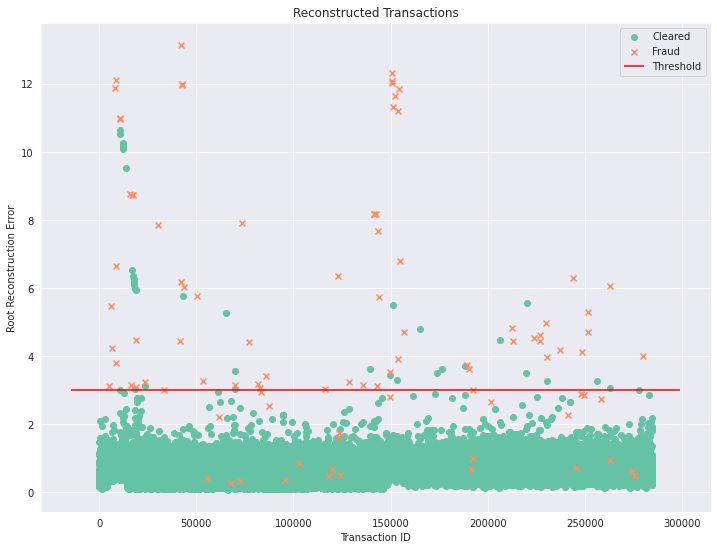


 Confusion Matrix 



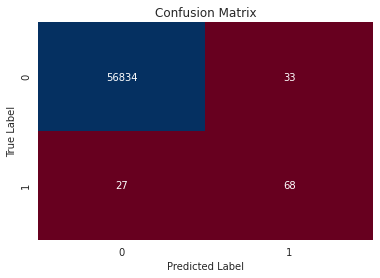


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56867
           1       0.67      0.72      0.69        95

    accuracy                           1.00     56962
   macro avg       0.84      0.86      0.85     56962
weighted avg       1.00      1.00      1.00     56962



In [39]:
latent = 50 # dimension of the latent vector 5 
batch_size = 128
epochs = 100

# Defining the Model

inputs = Input(shape=(input_dim,), name = 'input_encoder')

encoder = Dense(15, activation='relu')(inputs) # 6
encoder = Dense(20, activation='relu')(encoder) # 9

bottleneck  = Dense(latent, activation='relu')(encoder)

decoder = Dense(20, activation='relu')(bottleneck)
decoder = Dense(15, activation='relu')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder_2 = Model(inputs,decoder)
# autoencoder_2.summary()
# keras.utils.plot_model(autoencoder_2, show_shapes=True)

# Compiling the model

autoencoder_2.compile(optimizer=keras.optimizers.Adam(),
                      loss = losses.mean_squared_error,
                      metrics = ['mae','accuracy'])

# Early Stopper

stopper = EarlyStopping(monitor = 'val_loss',
                        min_delta = 0.005,
                        verbose = 1,
                        patience = 5,
                        restore_best_weights = True)

# Training

history = autoencoder_2.fit(X_train, X_train,
                            batch_size = batch_size,
                            epochs = epochs,
                            verbose = 2,
                            validation_data = (X_test, X_test),
                            callbacks = [stopper])

LossGraph(history)

# Predicting

predictions = autoencoder_2.predict(X_test)

# Reconstruction error (RMSE)

rmse = np.sqrt(np.mean(np.power(X_test - predictions, 2), axis = 1))

# Reconstructed data

reconstructed = pd.DataFrame({'rec_error': rmse,'true_class': y_test})

frauds = reconstructed[reconstructed.true_class == 1].drop('true_class', axis = 1)
cleared = reconstructed[reconstructed.true_class == 0].drop('true_class', axis = 1)

# Predicting the class using the threshtold

threshold = 3

reconstructed['pred_class'] = 0
reconstructed.pred_class[reconstructed.rec_error > threshold] = 1

# Model Performance

ReconstructionScatter(cleared, frauds, threshold = threshold)
ModelPerformance(X_test, y_test, reconstructed.pred_class)

In [ ]:
# import time
# for i in range(60):
#   time.sleep(60)
#   print(i)